In [1]:
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
from scipy import linalg as LA
import pandas as pd
import time, os
import matplotlib.pyplot as plt

from pyinstrument import Profiler
import Ipynb_importer

from infoband.band_info import InfoCorrBand
from wlpy.covariance import Covariance
from utils.adpt_correlation_threshold import AdptCorrThreshold
from wlpy.gist import heatmap

import warnings
warnings.filterwarnings("ignore")

from my_api import *

# proposed estimator

In [2]:
# profiler = Profiler()
# profiler.start()

N = 100
T = 300
rho = 0.95
S = gen_S_AR1(N = N, rho = rho)
R = cov2cor(S)

seed = 1
rng = np.random.RandomState(seed) if 1 else np.random
X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)

# profiler.stop()
# profiler.print()

fro 0.5 random None


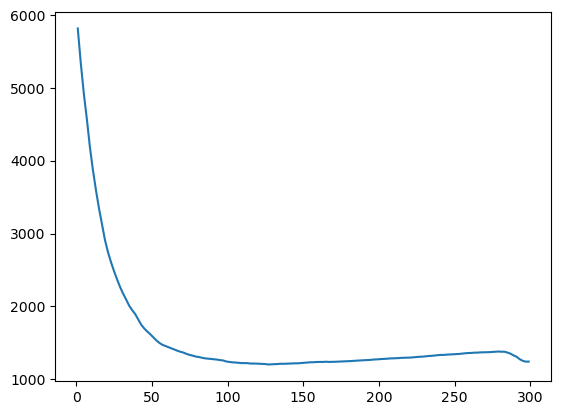

In [3]:
for ord in ['fro', 2]:
    for eta in [0.5, 0.8, 0.95, 1]:
        draw_type, near_factor = ('random', None)
        err_cor = []
        err_cov = []
        
        print(ord, eta, draw_type, near_factor)
        
        for i in range(100): 
            # if i not in [34, 62]:
                # continue
            if i != 23:
                continue

            profiler = Profiler()
            profiler.start()
            
            L = gen_L(S, eta, draw_type = draw_type, is_random = 0, near_factor = near_factor, rand_seed = i)
            c = InfoCorrBand(X, L, 50)
            R_est, S_est, k = c.auto_fit()
            
            print(i, k)
            profiler.stop()
            profiler.print()
            
            err_cor.append(LA.norm(R - R_est, ord))
            err_cov.append(LA.norm(S - S_est, ord))
        err_cor = err_cor / LA.norm(R, ord)
        err_cov = err_cov / LA.norm(S, ord)
        
        save_data_fig(err_cor, ord, 'cor', draw_type, eta, N, T, rho, near_factor, is_save = 1)
        save_data_fig(err_cov, ord, 'cov', draw_type, eta, N, T, rho, near_factor, is_save = 1)

# Other method

In [30]:
N = 500
T = 300
rho = 0.95
S = gen_S_AR1(N = N, rho = rho)
R = cov2cor(S)
seed = 1
rng = np.random.RandomState(seed) if 1 else np.random
X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)

In [31]:
# G_zero = np.zeros((N, N))
G_zero = np.ones((N, N)) - np.eye(N)
m = AdptCorrThreshold(pd.DataFrame(X), G_zero)

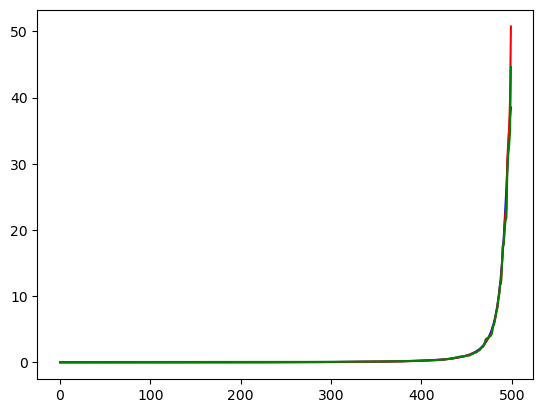

In [40]:
plt.plot(np.linalg.eigvals(S)[::-1], color = 'blue');
plt.plot(np.sort(np.linalg.eigvals(m.sample_cov())), color = 'red');
plt.plot(np.sort(np.linalg.eigvals(m.nonlin_shrink())), color = 'green');
# plt.plot(np.sort(np.linalg.eigvals(m.lw_lin_shrink())), color = 'purple');

In [1]:
# help('numpy.linalg.eigvals')

In [34]:
# np.linalg.eigvals(S)[::-1]
# np.linalg.eigvals(m.sample_cov())[::-1]

In [36]:
def show_rs(S: np.ndarray, 
            m: AdptCorrThreshold, 
            ord = 'fro'):
    # ord: norm type
    R_ths, S_ths, params = m.auto_fit(threshold_method = 'soft threshold')
    print(params)
    R_thh, S_thh, params = m.auto_fit(threshold_method = 'hard threshold')
    print(params)
    R = cov2cor(S)
    
    print(ord)
    print('----------'*2)
    
    x = LA.norm(R, ord)
    print('Correlation itself', x)
    print('Error:')
    print('Sample', LA.norm(cov2cor(m.sample_cov()) - R, ord) / x)
    print('Linear Shrinkage', LA.norm(cov2cor(m.lw_lin_shrink()) - R, ord) / x)
    print('Nonlinear Shrinkage', LA.norm(cov2cor(m.nonlin_shrink()) - R, ord) / x)
    print('Soft Threshold', LA.norm(R_ths - R, ord) / x)
    print('Hard Threshold', LA.norm(R_thh - R, ord) / x)
    for eta in [0.5, 0.8, 0.95, 1]:
        try:
            mean_err = np.loadtxt('data_done/' + get_title_1(ord, 'cor', 'random', eta, N, T, rho) + '.txt').mean()
            print('Info Band, eta={}'.format(eta), mean_err)
        except Exception:
            pass
        
    print()
    
    x = LA.norm(S, ord)
    print('Covariance itself', x)
    print('Error:')
    print('Sample', LA.norm(m.sample_cov() - S, ord) / x)
    print('Linear Shrinkage', LA.norm(m.lw_lin_shrink() - S, ord) / x)
    print('Nonlinear Shrinkage', LA.norm(m.nonlin_shrink() - S, ord) / x)
    print('Soft Threshold', LA.norm(S_ths - S, ord) / x)
    print('Hard Threshold', LA.norm(S_thh - S, ord) / x)
    for eta in [0.5, 0.8, 0.95, 1]:
        try:
            mean_err = np.loadtxt('data_done/' + get_title_1(ord, 'cov', 'random', eta, N, T, rho) + '.txt').mean()
            print('Info Band, eta={}'.format(eta), mean_err)
        except Exception:
            pass
    
    print('----------'*2)
    return

In [39]:
print(N, T, rho)
show_rs(S, m, 'fro')
show_rs(S, m, 2)
# show_rs(S, m, 1)

[ 6.43220455e-01 -6.03734560e-04]
[ 6.71717172e+00 -1.55865402e-12]
fro
--------------------
Correlation itself 97.80866615094732
Error:
Sample 0.30145095089923946
Linear Shrinkage 0.2839944980445308
Nonlinear Shrinkage 0.2732307754636863
Soft Threshold 0.21751200955816563
Hard Threshold 0.9735165500676309

Covariance itself 97.80866615094732
Error:
Sample 0.3147680811469419
Linear Shrinkage 0.2971016162330117
Nonlinear Shrinkage 0.28522658188781924
Soft Threshold 0.2366022311315699
Hard Threshold 0.9737125716827223
--------------------
[ 2.41818635e-08 -1.97730196e-12]
[ 0.25467745 -0.2535231 ]
2
--------------------
Correlation itself 38.50264813100928
Error:
Sample 0.4033757099900365
Linear Shrinkage 0.3067950387124192
Nonlinear Shrinkage 0.26779469092129193
Soft Threshold 0.9740277604647505
Hard Threshold 0.9740277604647505

Covariance itself 38.50264813100928
Error:
Sample 0.43164797923813863
Linear Shrinkage 0.3292782219862578
Nonlinear Shrinkage 0.2930379819326254
Soft Threshold

# ----------------------------
plot the distribution of error rates

In [ ]:
# res1 = []
# res2 = []

In [ ]:
for i in range(200):
    L1 = gen_L(S, eta = 0.5, verbose = 0, 
            draw_type = 'near', is_random = 1)
    c1 = InfoCorrBand(X = X, L = L1, num_cv = 20)
    # R_est1, S_est1, k1 = c1.auto_fit()
    res = c1.auto_fit()
    res1.append(res)
    # print(res[2])

20
18
18
6
17
15
19
19
6
10
6
7
7
16
22
24
19
17
4
7
16
20
3
17
21
25
6
7
8
22
5
23
16
21
21
14
4


KeyboardInterrupt: 

# --------------------

In [ ]:
for ord in ['fro', 2, 1]:
    print(ord, 'cor')
    print(LA.norm(R - R_est, ord))
    print(LA.norm(R - R_est1, ord))
    print(LA.norm(R - R_est2, ord))
    print(ord, 'cov')
    print(LA.norm(S - S_est, ord))
    print(LA.norm(S - S_est1, ord))
    print(LA.norm(S - S_est2, ord))

fro cor
5.3547379898153045
6.452088354585957
12.623341873998882
fro cov
8.20827979110684
8.9617152976866
13.40982410842072
2 cor
1.7832402677573187
1.769745999552205
4.998685228078624
2 cov
4.977860270444561
4.96973660159217
5.091390155453619
1 cor
3.9752892005894385
4.283611905894455
6.733673932336882
1 cov
8.690140091661135
8.734167335328328
8.482216067368222


In [ ]:
df = pd.DataFrame({'a':[[2,3],2,3]})
df

,a
0,"[2, 3]"
1,2
2,3


In [ ]:
# heatmap(R)
# heatmap(R_est)
# heatmap(R_est1)
# heatmap(R_est2)
# heatmap(c.sample_corr())

In [ ]:
c.auto_fit()

(array([[1.        , 0.75607612, 0.57857393, ..., 0.        , 0.        ,
         0.        ],
        [0.75607612, 1.        , 0.81429886, ..., 0.        , 0.        ,
         0.        ],
        [0.57857393, 0.81429886, 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.81889317,
         0.66621149],
        [0.        , 0.        , 0.        , ..., 0.81889317, 1.        ,
         0.84207442],
        [0.        , 0.        , 0.        , ..., 0.66621149, 0.84207442,
         1.        ]]),
 array([[1.06586502, 0.75682257, 0.58198612, ..., 0.        , 0.        ,
         0.        ],
        [0.75682257, 0.94005854, 0.76924368, ..., 0.        , 0.        ,
         0.        ],
        [0.58198612, 0.76924368, 0.94930403, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.98563935, 0.82672521,
         0.81246694],
        [0. 

In [ ]:
class time_printer():
    def __init__(self):
        self.t = time.time()
        self.t_next = None
        
    def tick(self):
        self.t_next = time.time()
        print("    Time Interval: {}".format(self.t_next - self.t))
        self.t = self.t_next

In [ ]:
is_random = False
rng = (random if is_random else np.random.RandomState(100)) # 300_300:101. other: 100
N = 400
T = 300
res = []
rho_range = [0.8, 0.9, 0.95, 0.99]
eta_range = [0.5, 0.8, 1]
ord_range = ['fro', 2]
near_factor_range = [0.5, 1, 2]
tp = time_printer()

In [ ]:
print(N, T)
for rho in rho_range:
    print("rho: ", rho)
    
    S = gen_S_AR1(rho = rho, N = N)
    R = cov2cor(S)
    X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)
    
    m = Covariance(X)
    S_l = m.lw_lin_shrink()
    R_l = cov2cor(S_l)
    S_nl = m.nonlin_shrink()
    R_nl = cov2cor(S_nl)
    
    tp.tick()
    
    for eta in eta_range:
        for near_factor in near_factor_range:
            print("eta, near_factor: ", eta, near_factor)
            
            L = gen_L(S, eta, 
                draw_type = 'near', 
                is_random = is_random, 
                near_factor = near_factor)   
            
            tp.tick()
                
            c = InfoCorrBand(X, L)
            
            tp.tick()
            
            R_est, S_est = c.auto_fit()[:2]
            
            tp.tick()
            
            for ord in ord_range:   
                print("ord: ", ord)
                
                dct_cov = {'group': 'S', 
                    'norm type': ord, 
                    'rho': rho, 
                    'eta': eta, 
                    'near factor': near_factor, 
                    'S or R': LA.norm(S, ord), 
                    'Sample': LA.norm(c.sample_cov() - S, ord), 
                    'Linear Shrinkage': LA.norm(S_l - S, ord), 
                    'Nonlinear Shrinkage': LA.norm(S_nl - S, ord), 
                    'Info Band': LA.norm(S_est - S, ord)}
                dct_cor = {'group': 'R', 
                    'norm type': ord, 
                    'rho': rho, 
                    'eta': eta, 
                    'near factor': near_factor, 
                    'S or R': LA.norm(R, ord), 
                    'Sample': LA.norm(c.sample_corr() - R, ord), 
                    'Linear Shrinkage': LA.norm(R_l - R, ord), 
                    'Nonlinear Shrinkage': LA.norm(R_nl - R, ord), 
                    'Info Band': LA.norm(R_est - R, ord)}
                res += [dct_cov, dct_cor]
                
                tp.tick()

400 300
rho:  0.8
    Time Interval: 0.9151647090911865
eta, near_factor:  0.5 0.5
    Time Interval: 4.885119199752808
    Time Interval: 0.07583808898925781


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(res)
df

In [ ]:
path = 'resultData/'
file_name = 'result_' + str(N) + '-' + str(T) + '.csv'
df.to_csv(path + file_name)
# df.to_csv(path + file_name, float_format = '%.5f') 

dataframe 追加模式 https://blog.csdn.net/lost0910/article/details/105321888

# test

In [ ]:
N = 400
T = 400
S = gen_S_AR1(rho = 0.9, N = N)
R = cov2cor(S)
X = np.random.multivariate_normal(mean = np.zeros(N), cov = S, size = T)
m = Covariance(X)
S_nl = m.nonlin_shrink()
print(S_nl)
lam, u = np.linalg.eigh(m.sample_cov())
print(lam)